In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report
import seaborn as sns
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot
from sklearn import tree
from matplotlib.colors import ListedColormap
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone
from scipy.stats import mode

In [3]:
# Create dataset.
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [4]:
# Split the dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

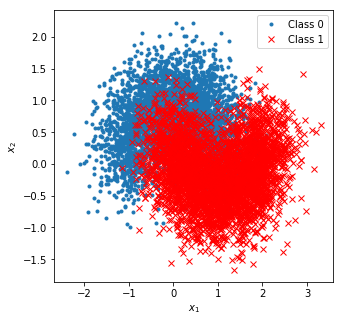

In [5]:
idx0 = np.argwhere(y_train == 0)
idx1 = np.argwhere(y_train == 1)

fig = plt.figure(figsize=(5,5))
plt.plot(X_train[idx0,0], X_train[idx0,1], '.', label='Class 0')
plt.plot(X_train[idx1,0], X_train[idx1,1], 'rx', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [6]:
n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

# Using Grid Search to fine-tune 'max_leaf_nodes' hyperparameter

In [7]:
# Set parameters for grid-search.
param_grid = [{'max_leaf_nodes': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}]

# Instantiate DT class.
reg = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(reg, param_grid, cv=5, verbose=3, n_jobs=-1)

# Find best hyperparameters.
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_leaf_nodes': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [8]:
grid_search.best_params_

{'max_leaf_nodes': 16}

In [14]:
forest = [clone(grid_search.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8024511999999999

In [15]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [16]:
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [17]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8668